In [1]:
import os
import time
import dill
from typing import List
from functools import reduce
from calendar import monthrange

In [2]:
import json
import csv
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import urllib.request as urllib2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from random import sample, randint, shuffle
from sklearn.decomposition import PCA

In [4]:
import nltk
import text_summarizer
from gensim.utils import simple_preprocess
from gensim.summarization.summarizer import summarize
from gensim.models import Word2Vec, LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [5]:
from time import process_time

In [6]:
t = process_time()
dill.load_session('thesis_env.db')
process_time() - t

39.948508

In [7]:
len(adjectives)

393

In [8]:
len(all_)

1685787

## Gender-neutral adjectives describing people

In [10]:
with open('cities.csv') as csv_file:
    cities = csv_file.read().split(",")

In [11]:
cities = [x.lower() for x in cities]

In [373]:
url = 'http://ideonomy.mit.edu/essays/traits.html'
file = urllib2.urlopen(url)
html = file.read()
file.close()
soup = BeautifulSoup(html)

In [381]:
soup.find_all('li')[0].contents[0].strip()

'Accessible'

In [389]:
adjs = [x.contents[0].strip().lower() for x in soup.find_all('li')]

In [386]:
len(adjectives)

393

In [396]:
adjectives[:10]

['able',
 'abnormal',
 'above average',
 'absent-minded',
 'adventurous',
 'affectionate',
 'agile',
 'agreeable',
 'alert',
 'amazing']

In [399]:
adjs_all = adjs + [x for x in adjectives if x not in adjs]
len(adjs_all)

882

In [400]:
len([x for x in adjs_all if x in vocab])

508

In [397]:
[x for x in adjectives if x not in adjs][:10]

['able',
 'abnormal',
 'above average',
 'absent-minded',
 'affectionate',
 'agile',
 'amazing',
 'analytical',
 'angelic',
 'apprehensive']

In [398]:
adjs[:10]

['accessible',
 'active',
 'adaptable',
 'admirable',
 'adventurous',
 'agreeable',
 'alert',
 'allocentric',
 'amiable',
 'anticipative']

In [ ]:
# adjs = [x.contents[0] for x in BeautifulSoup(html).find_all(attrs={"class": "wordlist-item"})]

In [89]:
# url = 'https://www.enchantedlearning.com/wordlist/adjectivesforpeople.shtml'
# file = urllib2.urlopen(url)
# html = file.read()
# file.close()
# soup = BeautifulSoup(html)

In [8]:
# adjs = [x.contents[0] for x in BeautifulSoup(html).find_all(attrs={"class": "wordlist-item"})]

In [16]:
# with open('adjectives.csv', mode='w') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerow(adjs)

In [5]:
with open('adjectives.csv') as csv_file:
    adjectives = csv_file.read().split(",")

In [6]:
adjectives[:5]

['able', 'abnormal', 'above average', 'absent-minded', 'adventurous']

In [7]:
dill.dump_session('thesis_env.db')

In [5]:
# url = 'https://www.britannica.com/topic/list-of-cities-and-towns-in-the-United-States-2023068'
# file = urllib2.urlopen(url)
# html = file.read()
# file.close()
# soup = BeautifulSoup(html)  

In [6]:
# alist = soup.find_all(attrs={"class": "md-crosslink"})

In [7]:
# places = [a.contents[0] for a in alist[3:]]

In [8]:
# len(places)

2010

In [51]:
grammar = ['a', 'an', 'the', \
           'for', 'and', 'nor', 'but', 'or', 'yet', 'so', \
           'after', 'as', 'before', 'if', 'inasmuch', 'now', \
           'once', 'since', 'supposing', 'though', 'until', \
           'whenever', 'whereas', 'wherever', 'which', \
           'although', 'because', 'even', 'lest', 'both', 'either', \
           'hardly', 'when', 'neither', 'than', 'whether', \
           'consequently', 'finally', 'furthermore', 'hence', \
           'however', 'incidentally', 'indeed', 'instead', 'likewise', \
           'meanwhile', 'about', 'above', 'across', 'after', 'ago', \
           'at', 'below', 'by', 'during', 'for', 'in', \
           'on', 'over', 'past', 'since', 'through', 'to', \
           'up', 'amid', 'atop', 'onto', \
           'throughout', 'upon', 'within', 'without']

In [9]:
# with open('cities.csv', mode='w') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerow(places)

# Data Parsing and Processing

In [13]:
class Doc:
    def __init__(self, id: int, gdescriptors: List[str], descriptors: List[str], text: str) -> None:
        self.id = id
        self.gdescriptors = gdescriptors
        self.descriptors = descriptors
        self.text = text

In [14]:
def parse_doc(file: str) -> Doc:
    tree = ET.parse(file)
    root = tree.getroot()
    try:
        fulltext = root.find('body').find('body.content').find("*[@class='full_text']")
        text = reduce(lambda x, y: x + y, [x.text for x in fulltext.findall('p')])
        id = int(root.find('head').find('docdata').find('doc-id').attrib['id-string'])
        classifiers = root.find('head').find('docdata').find('identified-content')
        gclassifiers = classifiers.findall("*[@class='online_producer'][@type='general_descriptor']")
        dclassifiers = classifiers.findall("*[@class='online_producer'][@type='descriptor']")
        gdescriptors = [c.text for c in gclassifiers]
        descriptors = [c.text for c in dclassifiers]
        return Doc(id, gdescriptors, descriptors, text)
    except:
        return None

In [15]:
def get_docs_by_month(year: int, month: int) -> List[Doc]:
    days = monthrange(year, month)[1]
    docs = []
    for day in range(1, days+1):
        for file in os.listdir(f'data/{year}/{month:02}/{day:02}/'):
            doc = parse_doc(f'data/{year}/{month:02}/{day:02}/{file}')
            if doc:
                docs.append(doc)
    return docs

In [13]:
t = time.process_time()
all_ = []
for y in range(1988, 2007):
    print(y)
    for i in range(1,13):
        all_ += get_docs_by_month(y, i)
time.process_time() - t

1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


973.445533

In [16]:
len(all_)

1685787

In [15]:
dill.dump_session('thesis_env.db')

# Saving files locally and loading

In [18]:
with open('alldocs.json', 'w') as outfile:
    json.dump([x.__dict__ for x in all_], outfile)

In [19]:
def save(i, arr):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'w') as outfile:
        json.dump([x.__dict__ for x in arr], outfile)
    print(time.process_time() - t)

In [20]:
def load(i):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'r') as infile:
        l = json.load(infile)
    print(time.process_time() - t)
    return l

In [11]:
save(0, all_[:600000])

26.122622999999976


In [12]:
l0 = load(0)

89.333306


In [13]:
save(1, all_[600000:1200000])

34.060252999999875


In [14]:
l1 = load(1)

102.26382799999988


In [15]:
save(2, all_[1200000:])

31.626627999999982


In [16]:
l2 = load(2)

19.019525000000158


In [17]:
l = l0 + l1 + l2
len(l)

1685787

# Process by descriptor

In [10]:
t = time.process_time()
alld = {}
for doc in all_:
    doc = Doc(doc.id, doc.gdescriptors, doc.descriptors, doc.text)
    for d in doc.descriptors:
        count, docs = alld.get(d, (0, set()))
        docs.add(doc)
        alld[d] = (count + 1, docs)
time.process_time() - t

44.409671

In [11]:
alldlist = sorted([(d, alld[d][0], alld[d][1]) for d in alld], key=lambda x: x[1], reverse=True)
for x in range(15):
    print(alldlist[x][0:2])

('Terrorism', 12393)
('Books and Literature', 11222)
('Politics and Government', 10589)
('Baseball', 9039)
('United States Politics and Government', 8295)
('Motion Pictures', 7748)
('Music', 7317)
('Weddings and Engagements', 7280)
('Medicine and Health', 6829)
('Travel and Vacations', 6537)
('Deaths (Obituaries)', 6438)
('Television', 6171)
('Football', 6070)
('Computers and the Internet', 5952)
('Basketball', 5746)


In [141]:
def exclude(e, x):
    for d in x.descriptors:
        if d == e:
            continue
        if d in [t[0] for t in alldlist[:30]]:
            return False
    return True

In [13]:
def getlist(topic):
    return list(filter(lambda x: exclude(topic, x), alld[topic][1]))

In [110]:
politics = getlist('Politics and Government')

In [111]:
movies = getlist('Motion Pictures')

In [74]:
books = getlist('Books and Literature')

In [447]:
sports = getlist('Baseball') + getlist('Football')

In [112]:
len(politics), len(movies), len(books), len(sports)

(9979, 7374, 10499, 7370)

In [19]:
politics = sample(politics, 7370)

In [20]:
movies = sample(movies, 7370)

In [21]:
books = sample(books, 7370)

In [22]:
sports = sample(sports, 7370)

# WordNet

In [271]:
from nltk.corpus import wordnet as wn

In [281]:
wn.synsets('person')

[Synset('person.n.01'), Synset('person.n.02'), Synset('person.n.03')]

In [277]:
person = wn.synset('person.n.01')
man = wn.synset('man.n.01')
woman = wn.synset('woman.n.01')

In [279]:
man.path_similarity(person), woman.path_similarity(person), man.path_similarity(woman)

(0.3333333333333333, 0.3333333333333333, 0.3333333333333333)

In [352]:
president = wn.synset('president.n.01')
nurse = wn.synset('nurse.n.01')
teacher = wn.synset('teacher.n.01')
girl = wn.synset('girl.n.01')
mother = wn.synset('mother.n.01')
brother = wn.synset('brother.n.01')
female = wn.synset('female.n.02')
male = wn.synset('male.n.02')
tall = wn.synset('tall.a.01')
maid = wn.synset('maid.n.01')
home = wn.synset('home.n.01')

In [328]:
smart.path_similarity(wn.synset('male.a.01'))

In [332]:
woman.path_similarity(home), man.path_similarity(home)

(0.08333333333333333, 0.08333333333333333)

In [333]:
mother.path_similarity(girl), mother.path_similarity(person), mother.path_similarity(female), mother.path_similarity(male)

(0.1, 0.14285714285714285, 0.125, 0.125)

In [353]:
for x in [president, nurse, teacher, girl, mother, brother, schoolgirl, maid, female]:
    print(man.path_similarity(x), woman.path_similarity(x), male.path_similarity(x), female.path_similarity(x))

0.1111111111111111 0.1111111111111111 0.125 0.125
0.2 0.2 0.16666666666666666 0.16666666666666666
0.2 0.2 0.16666666666666666 0.16666666666666666
0.25 0.5 0.2 0.3333333333333333
0.1111111111111111 0.1111111111111111 0.125 0.125
0.14285714285714285 0.14285714285714285 0.16666666666666666 0.16666666666666666
0.16666666666666666 0.25 0.2 0.3333333333333333
0.14285714285714285 0.14285714285714285 0.16666666666666666 0.16666666666666666
0.25 0.5 0.3333333333333333 1.0


# SentiWordNet

In [345]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/mayjiang/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


In [371]:
sman = swn.senti_synset('man.n.01')
swoman = swn.senti_synset('woman.n.01')
tall = swn.senti_synset('tall.a.01')
maid = swn.senti_synset('maid.n.01')
smart = swn.senti_synset('smart.a.01')
awesome = swn.senti_synset('awesome.a.01')
shy = swn.senti_synset('shy.a.01')
liberal = swn.senti_synset('liberal.a.01')
conservative = swn.senti_synset('conservative.a.01')
moderate = swn.senti_synset('moderate.a.01')
demanding = swn.senti_synset('demanding.a.01')

In [372]:
for s in [sman, swoman, tall, maid, smart, awesome, shy, liberal, conservative, moderate, demanding]:
    print(s)

<man.n.01: PosScore=0.0 NegScore=0.0>
<woman.n.01: PosScore=0.0 NegScore=0.0>
<tall.a.01: PosScore=0.5 NegScore=0.0>
<maid.n.01: PosScore=0.0 NegScore=0.0>
<smart.a.01: PosScore=0.5 NegScore=0.0>
<amazing.s.02: PosScore=0.875 NegScore=0.125>
<diffident.a.02: PosScore=0.25 NegScore=0.25>
<broad.s.08: PosScore=0.625 NegScore=0.0>
<conservative.a.01: PosScore=0.0 NegScore=0.0>
<moderate.a.01: PosScore=0.25 NegScore=0.625>
<demanding.a.01: PosScore=0.0 NegScore=0.375>


In [401]:
# Sentiment Bias - weighted projection bias, each word multiplied by (pos_score - neg_score)


In [441]:
sbias(getg(mbooks), mbooks)

neg -0.20761971 0.25 caring
pos 0.12445271 0.375 confident
pos 0.10769328 0.25 contemplative
pos 0.16988644 0.25 firm
neg -0.16727082 0.125 friendly
pos 0.17441696 0.625 liberal
pos 0.13595861 0.625 logical
pos 0.27562273 -0.375 moderate
neg -0.17365715 0.25 patient
pos 0.14351737 0.125 patriotic
pos 0.1057783 0.375 rational
neg -0.25844532 0.625 sexy
neg -0.18216969 0.375 warm
pos 0.11109869 0.5 winning
neg -0.21810304 0.5 cute
neg -0.22588326 0.375 emotional
neg -0.21726993 0.375 glamorous
pos 0.11444926 0.625 moralistic
pos 0.10260116 0.625 progressive
neg -0.25614166 0.125 sensual
neg -0.17997913 0.125 anxious
pos 0.104796335 -0.75 cold
pos 0.23928382 -0.875 criminal
pos 0.11037847 -0.5 critical
neg -0.15172711 -0.625 discontented
neg -0.15982822 0.125 disloyal
pos 0.17313033 -0.125 fanatical
pos 0.26991513 0.25 grand
pos 0.10619152 0.125 hidebound
pos 0.15393595 -0.375 moody
pos 0.19790758 -0.75 paranoid
pos 0.10387065 0.375 provocative
pos 0.15288518 -0.5 reactionary
neg -0.16902

(0.061671779339609586, 0.08620689655172414, 0.21634615384615385)

In [440]:
sbias(getg(mpol), mpol)

neg -0.19597507 0.625 accessible
pos 0.15286292 0.5 charismatic
pos 0.11145699 0.125 conciliatory
neg -0.15788443 0.875 decent
neg -0.16832036 0.75 healthy
neg -0.16127829 0.25 intelligent
pos 0.19596937 0.5 loyal
neg -0.19834132 0.125 neat
neg -0.35829028 0.25 patient
neg -0.17002498 0.75 precise
neg -0.16689934 -0.25 simple
pos 0.11683028 0.25 steadfast
pos 0.13272035 0.625 suave
pos 0.10439743 0.5 winning
neg -0.16523525 0.375 busy
pos 0.19985822 -0.75 earthy
neg -0.15106884 -0.125 ordinary
pos 0.12091027 -0.125 outspoken
neg -0.17384371 -0.125 private
neg -0.16532537 0.25 pure
pos 0.11442726 0.25 smooth
pos 0.14168674 0.5 crafty
pos 0.12447191 0.125 disloyal
neg -0.16128409 -0.625 disobedient
pos 0.12090054 -0.25 disorganized
pos 0.12598191 0.375 fatalistic
pos 0.112024866 -0.125 gloomy
pos 0.18825054 -0.375 mannered
pos 0.106990054 0.125 ruined
neg -0.17413384 0.25 amazing
neg -0.20340455 0.75 beautiful
neg -0.16406856 0.125 bright
pos 0.103838444 -0.625 caustic
pos 0.10076103 0.1

(0.06415719592100227, 0.06, 0.15)

In [420]:
gproj(getg(mpol), mpol, 'he'), gproj(getg(mpol), mpol, 'she')

(0.24627662, -0.45324638)

In [439]:
def sbias(g, m):
    b = 0
    l = list(filter(lambda x: x in m.wv.vocab, adjs_all))
    p, n, np, nn = 0, 0, 0, 0
    for x in l:
        proj = gproj(g, m, x)
        b += abs(proj)
        try:
            s = swn.senti_synset(x + ".a.01")
            score = s.pos_score() - s.neg_score()
            if proj < -0.15 and score != 0:
                print("neg", proj, score, x)
                n += score
                nn += 1
            if proj > 0.1 and score != 0:
                print("pos", proj, score, x)
                p += score
                np += 1
        except:
            continue
    return b/len(l), p/np, n/nn

# Experiment: Male/Female Ratio

In [180]:
lists = []
labels = []
for c in alldlist[:30]:
    l = getlist(c[0])
    if len(l) > 2000:
        print(c[0], len(l))
        lists.append(l)
        labels.append(c[0])
len(lists)

Terrorism 6899
Books and Literature 7787
Politics and Government 5649
Baseball 8270
United States Politics and Government 3634
Motion Pictures 5895
Music 4838
Weddings and Engagements 7167
Medicine and Health 5079
Travel and Vacations 4555
Deaths (Obituaries) 3738
Television 4294
Football 5593
Computers and the Internet 4201
Basketball 5410
Art 3846
Theater 3901
Suits and Litigation 3275
United States International Relations 2496
United States Armament and Defense 2212
International Relations 2631
Children and Youth 2207
Education and Schools 3074
Elections 2068
Environment 2415
Housing 2784
Automobiles 2639


27

In [146]:
def heshestats(m, w1, w2):
    c1 = m.wv.vocab[w1].count #+ m.wv.vocab[w1_].count
    c2 = m.wv.vocab[w2].count #+ m.wv.vocab[w2_].count
    #print(c1, c2, c2/c1)
    return c2/c1

In [144]:
ms = []
for l in lists:
    m = getw2v(sample(l, 2000))
    heshestats(m, 'he', 'she')
    ms.append(m)

14443 2707 0.18742643495118744
18728 8495 0.4535988893635199
16770 2663 0.15879546809779368
29126 492 0.016892123875575087
17186 2469 0.14366344699173747
15933 6101 0.3829159605849495
14728 5602 0.38036393264530144
5119 5182 1.0123070912287555
12091 6448 0.5332892233892979
6763 3332 0.49268076297501107
23219 4969 0.21400577113570782
14508 5507 0.37958367797077475
23644 580 0.024530536288276096
10146 3115 0.30701754385964913
22276 1743 0.07824564553779853
16604 5778 0.34798843652132017
13167 7451 0.5658844079896711
13943 4111 0.2948432905400559
12174 1353 0.11113849186791523
14805 2654 0.17926376224248564
10496 1374 0.13090701219512196
14065 11199 0.7962317810167081
11147 6672 0.5985466941778057
18823 3508 0.18636774159273228
8298 2153 0.2594601108700892
12787 6793 0.5312426683350278
10026 1905 0.19000598444045483


In [147]:
heshes = []
for m in ms:
    heshes.append(heshestats(m, 'he', 'she'))

In [181]:
biases = []
i = 0
for m in ms:
    b = bias(getg(m), m, m.wv.vocab, proflist)
    print(heshestats(m, 'he', 'she'), b, labels[i])
    i += 1
    biases.append(b)

0.18742643495118744 0.10755114227638267 Terrorism
0.4535988893635199 0.04351092342586462 Books and Literature
0.15879546809779368 0.08117492493491607 Politics and Government
0.016892123875575087 0.23906051099345269 Baseball
0.14366344699173747 0.10965769848256052 United States Politics and Government
0.3829159605849495 0.07131090098361408 Motion Pictures
0.38036393264530144 0.0511600704294268 Music
1.0123070912287555 0.1493787405409173 Weddings and Engagements
0.5332892233892979 0.0746384320254947 Medicine and Health
0.49268076297501107 0.039487039247005425 Travel and Vacations
0.21400577113570782 0.0834943001660846 Deaths (Obituaries)
0.37958367797077475 0.06178147751563449 Television
0.024530536288276096 0.23035889131755666 Football
0.30701754385964913 0.11230526598537284 Computers and the Internet
0.07824564553779853 0.15911339820761766 Basketball
0.34798843652132017 0.03524149366149776 Art
0.5658844079896711 0.056935037403313 Theater
0.2948432905400559 0.06072088706943589 Suits and

In [182]:
labels.index("Automobiles")

26

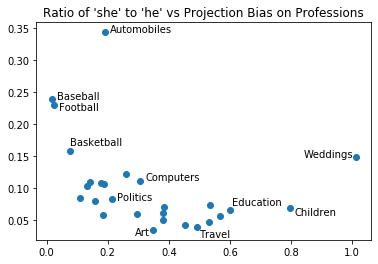

In [215]:
def coords(label):
    i = labels.index(label)
    return (heshes[i], biases[i])
plt.plot(heshes, biases, "o")
plt.title("Ratio of 'she' to 'he' vs Projection Bias on Professions")
plt.annotate("Automobiles", coords("Automobiles"), textcoords="offset points", xytext=(5,0))
plt.annotate("Weddings", coords("Weddings and Engagements"), textcoords="offset points", xytext=(-52,0))
plt.annotate("Baseball", coords("Baseball"), textcoords="offset points", xytext=(5,0))
plt.annotate("Football", coords("Football"), textcoords="offset points", xytext=(5,-5))
plt.annotate("Basketball", coords("Basketball"), textcoords="offset points", xytext=(0,5))
plt.annotate("Children", coords("Children and Youth"), textcoords="offset points", xytext=(5,-7))
plt.annotate("Education", coords("Education and Schools"), textcoords="offset points", xytext=(2,5))
plt.annotate("Computers", coords("Computers and the Internet"), textcoords="offset points", xytext=(5,0))
plt.annotate("Politics", coords("Politics and Government"), textcoords="offset points", xytext=(22,0))
plt.annotate("Travel", coords("Travel and Vacations"), textcoords="offset points", xytext=(2,-10))
plt.annotate("Art", coords("Art"), textcoords="offset points", xytext=(-18,-5))
plt.show()

# Experiment: Length

In [ ]:
# books is 10499 long, split into increments of 500

In [76]:
bookslist = []
for i in range(1, 21):
    bookslist.append(sample(books, i*500))

In [113]:
plist = []
for i in range(2, 20):
    plist.append(sample(politics, i*500))
plist.append(politics)

In [221]:
plistshort = []
for i in range(1, 10):
    plistshort.append(sample(politics, i*200))
pmodelsshort = [getw2v(p) for p in plistshort]
pbiasshort = [bias(getg(m), m, m.wv.vocab, proflist) for m in pmodelsshort]

In [224]:
blistshort = []
for i in range(1, 10):
    blistshort.append(sample(books, i*200))
bmodelsshort = [getw2v(b) for b in blistshort]
bbiasshort = [bias(getg(m), m, m.wv.vocab, proflist) for m in bmodelsshort]

In [448]:
slistshort = []
for i in range(1, 10):
    slistshort.append(sample(sports, i*200))
smodelsshort = [getw2v(s) for s in slistshort]
sbiasshort = [bias(getg(m), m, m.wv.vocab, proflist) for m in smodelsshort]

In [451]:
slist = []
for i in range(2, 14):
    slist.append(sample(sports, i*1000))
smodels = [getw2v(s) for s in slist]
sbias = [bias(getg(m), m, m.wv.vocab, proflist) for m in smodels]

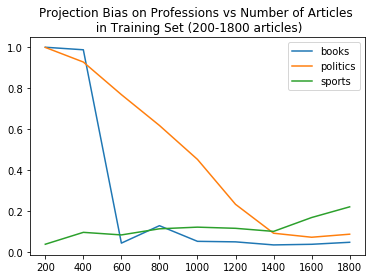

In [449]:
plt.plot([i*200 for i in range(1,10)], bbiasshort, label="books")
plt.plot([i*200 for i in range(1,10)], pbiasshort, label="politics")
plt.legend()
plt.title("Projection Bias on Professions vs Number of Articles \n in Training Set (200-1800 articles)")
plt.show()

In [114]:
pmodels = [getw2v(p) for p in plist]

In [82]:
booksmodels = [getw2v(b) for b in bookslist]

In [115]:
pbias = []
for m in pmodels:
    b = bias(getg(m), m, m.wv.vocab, proflist)
    print(b)
    pbias.append(b)

0.5772233574508546
0.0734701767039027
0.0688537814152118
0.08305388300997958
0.06266421009538382
0.05534665679485859
0.07938607440166894
0.06768135385776182
0.08162163002018975
0.08094774881021471
0.07494355367683826
0.09051752739804284
0.09702742212223557
0.10574751904139042
0.10613597846505556
0.10079952142610644
0.09749374895855079
0.09925294766243084
0.10362135741110567


In [94]:
bookbias = []
for bm in booksmodels:
    b = bias(getg(bm), bm, bm.wv.vocab, proflist)
    print(b)
    bookbias.append(b)

0.9727325638135275
0.045612330736406935
0.04454958280516756
0.04608471256797202
0.05587483647625891
0.05342771026891355
0.06256595694921771
0.0673831163421047
0.06619414358791284
0.06855078208813771
0.075337888015471
0.07627692876604004
0.08308898592561793
0.08104289494451168
0.08403255242510363
0.08511889418915994
0.09022001865134682
0.09121858018543917
0.09542696736488897
0.10060866628945977


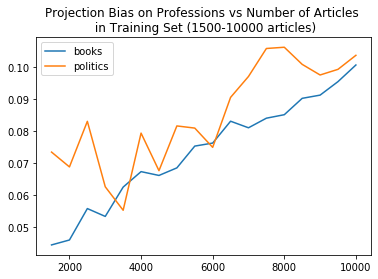

In [453]:
plt.plot([i*500 for i in range(3,21)], bookbias[2:], label="books")
plt.plot([i*500 for i in range(3,21)], pbias[1:], label="politics")
plt.legend()
plt.title("Projection Bias on Professions vs Number of Articles \n in Training Set (1500-10000 articles)")
plt.show()

[0.19302710774604992,
 0.23844998456397146,
 0.2893524986475313,
 0.27873200980463514,
 0.2543005048512266,
 0.3116570048239882,
 0.3102601092703866,
 0.30372024667422987,
 0.305594824975516,
 0.3274015368861792,
 0.35638563316315414,
 0.34060144879534776]

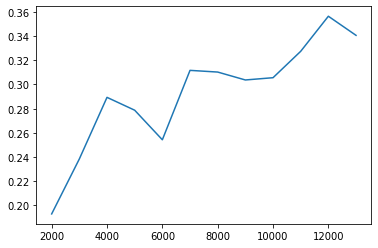

In [458]:
plt.plot([i*1000 for i in range(2,14)], sbias, label="s")
sbias

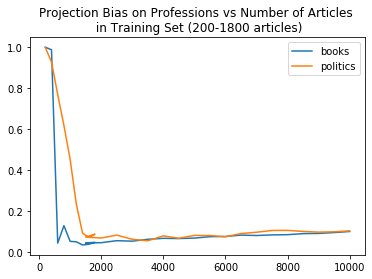

In [442]:
plt.plot([i*200 for i in range(1,10)] + [i*500 for i in range(3,21)], bbiasshort + bookbias[2:], label="books")
plt.plot([i*200 for i in range(1,10)] + [i*500 for i in range(3,21)], pbiasshort + pbias[1:], label="politics")
plt.legend()
plt.title("Projection Bias on Professions vs Number of Articles \n in Training Set (200-1800 articles)")
plt.show()

In [267]:
stereotypes_m = ['captain', 'president', 'principal', 'dean', \
                 'coach', 'director', 'officer', 'manager']
stereotypes_f = ['teacher', 'author', 'secretary', 'writer', \
                 'singer', 'teenager', 'editor', 'photographer']
male = ["male", "man", "boy", "boys", "brother", "he", "him", "son", "father"]
female = ["female", "woman", "girl", "girls", "sister", "she", "her", \
          "daughter", "mother"]
def cos_sim(m, x, y):
    wv1 = m.wv.get_vector(x)
    wv2 = m.wv.get_vector(y)
    sim = np.dot(wv1, wv2)/(np.linalg.norm(wv1)*np.linalg.norm(wv2))
    return sim
def s_word(m, w, A, B):
    return np.mean([cos_sim(m, w, a) for a in A]) - np.mean([cos_sim(m, w, b) for b in B])
def effect_size(m, X, Y, A, B):
    num = np.mean([s_word(m, x, A, B) for x in X]) - np.mean([s_word(m, y, A, B) for y in Y])
    return num/np.std([s_word(m, x, A, B) for x in X + Y])
def wbias(m):
    return effect_size(m, male, female, stereotypes_m, stereotypes_f)

In [268]:
bookwbias = []
for bm in booksmodels:
    b = wbias(bm)
    print(b)
    bookwbias.append(b)

0.084710464
-0.103254676
0.46582845
0.17834492
0.92044437
0.99255073
1.0072471
1.0636849
0.95142347
1.0167873
1.0270476
1.1150552
1.0032507
1.0011431
1.2693148
1.27527
1.2872465
1.2055503
1.1214428
1.2525442


In [269]:
pwbias = []
for m in pmodels:
    b = wbias(m)
    print(b)
    pwbias.append(b)

0.53966504
0.58441985
0.6321938
0.4419999
0.52009445
0.40268213
0.45781055
0.25239307
0.45995572
0.27195734
0.9551928
0.6784737
0.39555675
0.49233136
0.64562297
0.8364172
0.5080821
0.72874755
0.53683764


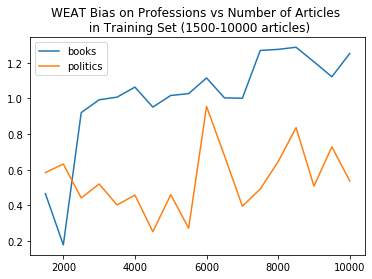

In [270]:
plt.plot([i*500 for i in range(3,21)], bookwbias[2:], label="books")
plt.plot([i*500 for i in range(3,21)], pwbias[1:], label="politics")
plt.legend()
plt.title("WEAT Bias on Professions vs Number of Articles \n in Training Set (1500-10000 articles)")
plt.show()

# Training Word Embeddings

In [81]:
def getw2v(category):
    sentences = []
    for t in category:
        sentences += nltk.sent_tokenize(t.text)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [24]:
t = time.process_time()
msports = getw2v(sports)
time.process_time() - t

95.68879

In [58]:
t = time.process_time()
msports1 = getw2v(sports + sports)
time.process_time() - t

163.753283

In [48]:
t = time.process_time()
msports2 = getw2v(sports + sports + sports + sports)
time.process_time() - t

371.57096499999994

In [60]:
t = time.process_time()
mpol = getw2v(politics)
time.process_time() - t

141.71859400000005

In [68]:
t = time.process_time()
mpol1 = getw2v(politics + politics)
time.process_time() - t

187.84100700000022

In [69]:
t = time.process_time()
mpol2 = getw2v(politics + politics + politics + politics)
time.process_time() - t

352.6542690000001

In [59]:
t = time.process_time()
mmov = getw2v(movies)
time.process_time() - t

115.31121599999994

In [70]:
t = time.process_time()
mmov1 = getw2v(movies + movies)
time.process_time() - t

261.3358850000004

In [71]:
t = time.process_time()
mmov2 = getw2v(movies + movies + movies + movies)
time.process_time() - t

421.18423699999994

In [61]:
t = time.process_time()
mbooks = getw2v(books)
time.process_time() - t

118.71266199999991

In [62]:
t = time.process_time()
mbooks1 = getw2v(books + books)
time.process_time() - t

231.03794900000003

In [63]:
t = time.process_time()
mbooks2 = getw2v(books + books + books + books)
time.process_time() - t

499.228335

In [10]:
def top5(word):
    for m in [mpol, mbooks, mmov, msports]:
        print([x[0] for x in m.wv.most_similar(positive=[word], topn=5)])

In [198]:
top5('house')

['supremacist', 'collar', 'plains', 'assembly', 'congressional']
['family', 'apartment', 'petal', 'mansion', 'farmhouse']
['mansion', 'houses', 'neighborhood', 'castle', 'cemetery']
['apartment', 'restaurant', 'store', 'shop', 'queens']


In [199]:
top5('success')

['difficulty', 'credibility', 'weakness', 'vision', 'strength']
['popularity', 'achievement', 'goal', 'fame', 'criticism']
['popularity', 'ambitions', 'hit', 'decline', 'commercial']
['experience', 'talent', 'confidence', 'patience', 'swagger']


In [200]:
top5('seat')

['seats', 'district', 'race', 'nomination', 'contest']
['chair', 'plane', 'truck', 'door', 'bedroom']
['chair', 'window', 'bed', 'truck', 'kitchen']
['seats', 'suite', 'apartment', 'gate', 'windows']


In [201]:
top5("best")

['good', 'greatest', 'whatever', 'whole', 'great']
['greatest', 'top', 'nonfiction', 'list', 'finest']
['oscars', 'prize', 'oscar', 'award', 'nominated']
['worst', 'greatest', 'biggest', 'strongest', 'toughest']


# Summarization

## TextRank

In [34]:
def getsummaries(category):
    s = []
    fails = []
    for i in range(len(category)):
        try:
            s.append(summarize(category[i].text, word_count=200))
        except:
            fails.append(i)
            print(i)
    return s, fails

In [ ]:
t = time.process_time()
summaries_pol, fpol = getsummaries(politics)
time.process_time() - t

In [35]:
t = time.process_time()
summaries_pol, fpol = getsummaries(politics)
time.process_time() - t

166
1831
5320
5643
6149
7366


109.888758

In [36]:
t = time.process_time()
summaries_mov, fmov = getsummaries(movies)
time.process_time() - t

1591
3842
6966


122.95149700000002

In [37]:
t = time.process_time()
summaries_bks, fbks = getsummaries(books)
time.process_time() - t

238
5562
6553
7021


121.83292399999993

## Centroid BOW Summarizer

In [82]:
def getbows(category):
    s = []
    centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
    for i in category:
        try:
            s.append(centroid_summarizer.summarize(i.text, limit=200-30))
        except:
            print(i)
    return s

In [39]:
t = time.process_time()
bow_pol = getbows(politics)
time.process_time() - t

134.52433099999996

In [40]:
len(bow_pol)

7370

In [83]:
t = time.process_time()
bow_bks = getbows(books)
time.process_time() - t

147.18170899999996

In [42]:
t = time.process_time()
bow_mov = getbows(movies)
time.process_time() - t

135.9884790000001

## Pseudo-summaries

In [43]:
def getctrls(category):
    ctrls = []
    for a in category:
        sents = nltk.sent_tokenize(a.text)
        rs = [i for i in range(len(sents))]
        shuffle(rs)
        ctrl = []
        count = 0
        for r in rs:
            if count > 200-5:
                break
            count += len(nltk.word_tokenize(sents[r]))
            ctrl.append(sents[r])
        summary = "\n".join([s for s in ctrl])
        ctrls.append(summary)
    return ctrls

In [44]:
t = time.process_time()
ctrls_pol = getctrls(politics)
time.process_time() - t

21.034067999999934

In [45]:
t = time.process_time()
ctrls_bks = getctrls(books)
time.process_time() - t

22.829864999999927

In [46]:
t = time.process_time()
ctrls_mov = getctrls(movies)
time.process_time() - t

22.42926299999999

# Training Word Embeddings on Summaries

In [47]:
def getw2v_s(sums):
    sentences = []
    for t in sums:
        sentences += nltk.sent_tokenize(t)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [48]:
mpol_s = getw2v_s(summaries_pol)

In [49]:
mbks_s = getw2v_s(summaries_bks)

In [50]:
mmov_s = getw2v_s(summaries_mov)

In [84]:
# mpol_b = getw2v_s(bow_pol)
mbks_b = getw2v_s(bow_bks)
# mmov_b = getw2v_s(bow_mov)

In [52]:
mpol_c = getw2v_s(ctrls_pol)
mbks_c = getw2v_s(ctrls_bks)
mmov_c = getw2v_s(ctrls_mov)

In [163]:
dill.dump_session('thesis_env2.db')

# Data Count

In [164]:
len(politics), len(books), len(movies), len(sports)

(7370, 7370, 7370, 7370)

In [204]:
for x in [politics, books, movies, sports]:
    print(np.mean([len(nltk.word_tokenize(a.text)) for a in x]))

1022.20434192673
1204.5089552238805
1174.7398914518317
975.4926729986431


In [167]:
for x in [politics, books, movies, sports]:
    print(sum([len(nltk.word_tokenize(a.text)) for a in x]))

7533646
8877231
8657833
7189381


In [169]:
for x in [summaries_pol, summaries_bks, summaries_mov, summaries_spts]:
    print(sum([len(nltk.word_tokenize(a)) for a in x]))

1651028
1728963
1776150
1693673


In [170]:
for x in [bow_pol, bow_bks, bow_mov, bow_spts]:
    print(sum([len(nltk.word_tokenize(a)) for a in x]))

1654079
1664973
1686927
1594135


In [175]:
for x in [ctrls_pol, ctrls_bks, ctrls_mov, ctrls_spts]:
    print(sum([len(nltk.word_tokenize(a)) for a in x]))

1651997
1610595
1624683
1594895


In [ ]:
for m in [mpol, mbooks, mmov, msports]:
    print(m.wv.vocab['she'].count, m.wv.vocab['he'].count)

In [183]:
for m in [mpol, mbooks, mmov, msports]:
    print(m.wv.vocab['her'].count, m.wv.vocab['him'].count)

7827 8938
36723 12895
26108 10990
1891 20541


In [184]:
for m in [mpol, mbooks, mmov, msports]:
    print(m.wv.vocab['woman'].count, m.wv.vocab['man'].count)

990 2431
3629 7280
3336 6874
191 2440


# Bias

In [144]:
vocab = vocab & set(msports.wv.vocab)
gspts = getg(msports)
bias(gspts, msports, vocab, proflist)

0.35275307


0.32663773588579276

In [146]:
summaries_spts, fspts = getsummaries(sports)

295
4071
4800
5414
7092


In [147]:
mspts_s = getw2v_s(summaries_spts)
bow_spts = getbows(sports)
mspts_b = getw2v_s(bow_spts)
ctrls_spts = getctrls(sports)
mspts_c = getw2v_s(ctrls_spts)

In [145]:
# mpol, mmov, mbooks, msports
# summaries_{pol, mov, bks, spts}
# m{pol, mov, bks}_{s, b, c}
# bow_{pol, mov, bks}
# ctrls_{pol, mov, bks}

In [156]:
mdict = {"politics": [], "books": [], "movies": [], "sports": []}
mdictadd([mpol, mmov, mbooks, msports])
mdictadd([mpol_s, mbks_s, mmov_s, mspts_s])
mdictadd([mpol_b, mbks_b, mmov_b, mspts_b])
mdictadd([mpol_c, mbks_c, mmov_c, mspts_c])

In [157]:
labels = ["original", "summary (TextRank)", "summary (Centroid-BOW)", "summary (control)"]
gdict = {"politics": [], "books": [], "movies": [], "sports": []}
gdictadd([mpol, mmov, mbooks, msports])
gdictadd([mpol_s, mbks_s, mmov_s, mspts_s])
gdictadd([mpol_b, mbks_b, mmov_b, mspts_b])
gdictadd([mpol_c, mbks_c, mmov_c, mspts_c])

0.34343678
0.52675015
0.5915069
0.35275307
0.31522945
0.78374213
0.62817353
0.49360958
0.31965494
0.8359838
0.7387123
0.51820844
0.32400513
0.768514
0.6437023
0.48822078


In [64]:
vocab = set(mpol.wv.vocab)
for m in [mpol, mmov, mbooks, msports]:
    vocab &= set(m.wv.vocab)
len(vocab)

16477

In [151]:
vocab_all = set(vocab)
for m in [mpol_s, mbks_s, mmov_s, mspts_s] + \
[mpol_b, mbks_b, mmov_b, mspts_b] + \
[mpol_c, mbks_c, mmov_c, mspts_c]:
    vocab_all &= set(m.wv.vocab)
len(vocab_all)

5573

In [152]:
vocab2 = vocab_all

In [90]:
proflist = list(filter(lambda x: x in mbooks.wv.vocab, [p[0] for p in profs]))

In [39]:
with open('debiaswe-master/data/equalize_pairs.json') as f:
    pairs = json.loads(f.read())
pairs = list(map(lambda x: [x[0].lower(), x[1].lower()], pairs))
with open('debiaswe-master/data/professions.json') as f:
    profs = json.loads(f.read())
# proflist = list(filter(lambda x: x in mpol.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))
with open('debiaswe-master/data/gender_specific_seed.json') as f:
    gender_specific = json.loads(f.read())
with open('objects.csv') as csv_file:
    objects = csv_file.read().split("\n")
objects[0] = 'angle'
with open('cities.csv') as csv_file:
    cities = csv_file.read().split(",")
cities = [x.lower() for x in cities]

In [83]:
def getg(m):
    matrix = []
    for a, b in pairs:
        if a not in m.wv.vocab or b not in m.wv.vocab:
            continue
        center = (m.wv.get_vector(a) + m.wv.get_vector(b))/2
        matrix.append(m.wv.get_vector(a) - center)
        matrix.append(m.wv.get_vector(b) - center)
    matrix = np.array(matrix)
    p = PCA(n_components = 10)
    p.fit(matrix)
    # print(p.explained_variance_ratio_[0])
#         plt.bar(range(10), p.explained_variance_ratio_)
#         plt.title("Explained Variance vs Component Number (" + t + ")")
    return p.components_[0]

In [135]:
def gproj2(g1, g2, m, w1):
    wvec = m.wv.get_vector(w1)
    # g = project wvec onto g1, g2 subspace
    A = np.hstack((g1.reshape(100,1),g2.reshape(100,1)))
    P = A @ np.linalg.inv(A.T @ A) @ A.T
    g = P @ wvec
    p = np.dot(g, wvec)/(np.linalg.norm(g)*np.linalg.norm(wvec))
    return p

In [136]:
gpol_s1, gpol_s2 = getg(mpol_s)
res = sorted([(x, gproj2(gpol_s1, gpol_s2, mpol_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(15):
    print(f"{res[i][0].ljust(15)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(15)} {res[-i-1][1]:.2f}")

0.3386617
though          0.00 		 chairman        0.87
proper          0.00 		 democrat        0.85
translate       0.00 		 speaker         0.81
combined        0.01 		 chief           0.79
modernity       0.01 		 james           0.79
fears           0.01 		 lawyer          0.78
moral           0.01 		 jr              0.78
excess          0.01 		 member          0.78
meaningful      0.01 		 leader          0.78
collection      0.01 		 secretary       0.77
sport           0.01 		 representative  0.77
dragging        0.01 		 john            0.76
practices       0.01 		 david           0.76
shifting        0.01 		 congressman     0.75
expenses        0.01 		 deputy          0.75


In [32]:
def gdictadd(models):
    for i in range(len(models)):
        gdict[list(gdict)[i]].append(getg(models[i]))

In [33]:
def mdictadd(models):
    for i in range(len(models)):
        mdict[list(mdict)[i]].append(models[i])

In [28]:
def gproj(g, m, w1):
    wvec = m.wv.get_vector(w1)
    p = np.dot(g, wvec)/(np.linalg.norm(g)*np.linalg.norm(wvec))
    return p

In [84]:
def bias(g, m, vocab, wordlist):
    b = 0
    l = list(filter(lambda x: x in vocab, wordlist))
    for x in l:
        b += abs(gproj(g, m, x))
    return b/len(l)

In [36]:
models

In [87]:
proflist = list(filter(lambda x: x in mbooks.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))

In [47]:
gdict = {"sports": [], "sports2": []}
mdict = {"sports": [], "sports2": []}
models = [msports, msports1]
gdictadd(models)
mdictadd(models)
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, proflist), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, adjectives), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, cities), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, objects), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, gender_specific))

0.34738272
0.2716877
    sports 0.298 0.164 0.266 0.231 0.334
   sports2 0.289 0.149 0.269 0.204 0.324


In [66]:
gdict = {"sports": [], "sports1": [], "sports2": []}
mdict = {"sports": [], "sports1": [], "sports2": []}
models = [msports, msports1, msports2]
gdictadd(models)
mdictadd(models)
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, proflist), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, adjectives), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, grammar), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, gender_specific))

0.34738272
0.28547773
0.23369507
    sports 0.306 0.166 0.129 0.352
   sports1 0.299 0.156 0.134 0.343
   sports2 0.242 0.132 0.117 0.297


In [72]:
gdict = {"mov": [], "mov1": [], "mov2": []}
mdict = {"mov": [], "mov1": [], "mov2": []}
models = [mmov, mmov1, mmov2]
gdictadd(models)
mdictadd(models)
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, proflist), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, adjectives), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, grammar), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, gender_specific))

0.5087397
0.40879804
0.3250344
       mov 0.085 0.087 0.039 0.172
      mov1 0.094 0.083 0.040 0.184
      mov2 0.096 0.082 0.046 0.188


In [73]:
gdict = {"pol": [], "pol1": [], "pol2": []}
mdict = {"pol": [], "pol1": [], "pol2": []}
models = [mpol, mpol1, mpol2]
gdictadd(models)
mdictadd(models)
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, proflist), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, adjectives), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, grammar), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, gender_specific))

0.34950238
0.3026881
0.26836872
       pol 0.091 0.070 0.053 0.125
      pol1 0.128 0.077 0.057 0.139
      pol2 0.111 0.079 0.055 0.144


In [67]:
gdict = {"books": [], "books1": [], "books2": []}
mdict = {"books": [], "books1": [], "books2": []}
models = [mbooks, mbooks1, mbooks2]
gdictadd(models)
mdictadd(models)
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, proflist), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, adjectives), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, grammar), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, gender_specific))

0.5940078
0.48473203
0.37103993
     books 0.100 0.067 0.038 0.159
    books1 0.123 0.081 0.038 0.178
    books2 0.138 0.087 0.038 0.189


In [ ]:
#todo

In [158]:
print(labels[0])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, proflist), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, adjectives), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, cities), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, objects), \
          "%.3f" % bias(gdict[i][0], mdict[i][0], vocab, gender_specific))

original
  politics 0.099 0.066 0.072 0.058 0.120
     books 0.086 0.092 0.089 0.080 0.173
    movies 0.096 0.069 0.077 0.065 0.155
    sports 0.327 0.175 0.258 0.228 0.372


In [159]:
print(labels[1])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, proflist), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, cities), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, objects), \
          "%.3f" % bias(gdict[i][1], mdict[i][1], vocab2, gender_specific))

summary (TextRank)
  politics 0.392 0.111 0.294 0.146 0.269
     books 0.052 0.051 0.044 0.052 0.161
    movies 0.083 0.089 0.064 0.084 0.192
    sports 0.303 0.154 0.182 0.180 0.283


In [160]:
print(labels[2])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, proflist), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, cities), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, objects), \
          "%.3f" % bias(gdict[i][2], mdict[i][2], vocab2, gender_specific))

summary (Centroid-BOW)
  politics 0.512 0.152 0.446 0.229 0.405
     books 0.048 0.054 0.046 0.048 0.163
    movies 0.069 0.077 0.067 0.088 0.194
    sports 0.337 0.181 0.209 0.198 0.298


In [161]:
print(labels[3])
for i in gdict:
    print("%10s" % i, \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, proflist), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, adjectives), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, cities), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, objects), \
          "%.3f" % bias(gdict[i][3], mdict[i][3], vocab2, gender_specific))

summary (control)
  politics 0.183 0.091 0.143 0.090 0.123
     books 0.046 0.045 0.037 0.049 0.137
    movies 0.066 0.069 0.051 0.068 0.172
    sports 0.246 0.115 0.145 0.135 0.197


In [162]:
gsports = getg(msports)
res = sorted([(x, gproj(gsports, msports, x)) for x in filter(lambda x: x in vocab, vocab)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.35275307
fielding   -0.48 		 ms         0.66
consistently -0.44 		 mrs        0.65
solid      -0.43 		 husband    0.64
shaky      -0.40 		 sang       0.62
switch     -0.40 		 house      0.58
hitting    -0.39 		 local      0.58
throwing   -0.38 		 store      0.58
hernández  -0.38 		 sister     0.57
crucial    -0.38 		 ann        0.56
starting   -0.37 		 songs      0.56


In [115]:
gpol = getg(mpol)
res = sorted([(x, gproj(gpol, mpol, x)) for x in filter(lambda x: x in vocab, vocab)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.34343678
her        -0.50 		 mr         0.43
women      -0.47 		 ouster     0.39
ms         -0.46 		 abbas      0.39
she        -0.46 		 mikhail    0.38
feeding    -0.37 		 mahmoud    0.37
disabled   -0.35 		 arafat     0.37
herself    -0.35 		 vladimir   0.37
mental     -0.34 		 himself    0.36
female     -0.34 		 kremlin    0.36
classroom  -0.32 		 hamid      0.35


In [117]:
gmov_s = getg(mmov_s)
res = sorted([(x, gproj(gmov_s, mmov_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.62817353
her        -0.57 		 disney     0.41
herself    -0.47 		 pictures   0.38
she        -0.44 		 production 0.35
husband    -0.41 		 studio     0.34
mother     -0.39 		 mr         0.34
ms         -0.38 		 producers  0.34
girl       -0.38 		 kong       0.34
woman      -0.36 		 paramount  0.33
daughter   -0.35 		 entertainment 0.33
single     -0.34 		 universal  0.32


In [119]:
gbks_s = getg(mbks_s)
res = sorted([(x, gproj(gbks_s, mbks_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.78374213
mr         -0.38 		 her        0.63
he         -0.32 		 she        0.47
his        -0.30 		 herself    0.46
administration -0.28 		 husband    0.42
iraq       -0.27 		 baby       0.37
president  -0.26 		 girl       0.35
military   -0.26 		 children   0.31
bush       -0.26 		 mother     0.30
nations    -0.26 		 sister     0.30
history    -0.24 		 love       0.29


In [97]:
gpol_s = getg(mpol_s)
res = sorted([(x, gproj(gpol_s, mpol_s, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(15):
    print(f"{res[i][0].ljust(15)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(15)} {res[-i-1][1]:.2f}")

0.3386617
chairman        -0.87 		 these           0.47
democrat        -0.82 		 large           0.46
speaker         -0.81 		 low             0.46
chief           -0.77 		 access          0.45
leader          -0.77 		 illegal         0.44
member          -0.77 		 prices          0.43
jr              -0.76 		 pay             0.42
secretary       -0.76 		 without         0.42
james           -0.76 		 oil             0.41
lawyer          -0.76 		 making          0.41
deputy          -0.75 		 flow            0.41
representative  -0.74 		 buy             0.41
richard         -0.74 		 real            0.40
aide            -0.74 		 raise           0.40
david           -0.73 		 stock           0.39


In [125]:
gpol_c = getg(mpol_c)
res = sorted([(x, gproj(gpol_c, mpol_c, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.32400513
mail       -0.37 		 head       0.52
or         -0.35 		 chairman   0.51
high       -0.35 		 union      0.51
got        -0.33 		 president  0.50
few        -0.32 		 leadership 0.48
com        -0.32 		 secretary  0.48
young      -0.31 		 chief      0.47
children   -0.31 		 powers     0.47
isn        -0.29 		 coalition  0.47
these      -0.28 		 leader     0.47


In [126]:
gbks_c = getg(mbks_c)
res = sorted([(x, gproj(gbks_c, mbks_c, x)) for x in filter(lambda x: x in vocab2, vocab2)], key=lambda x: x[1])
for i in range(10):
    print(f"{res[i][0].ljust(10)} {res[i][1]:.2f} \t\t {res[-i-1][0].ljust(10)} {res[-i-1][1]:.2f}")

0.768514
her        -0.61 		 mr         0.38
herself    -0.46 		 his        0.31
she        -0.46 		 war        0.29
husband    -0.41 		 he         0.28
children   -0.30 		 bush       0.27
love       -0.28 		 civil      0.24
ms         -0.27 		 administration 0.23
mother     -0.27 		 ii         0.23
girl       -0.27 		 iraq       0.22
woman      -0.27 		 policy     0.20


Text(0.5, 1.0, 'Explained Variance vs Component Number (Random)')

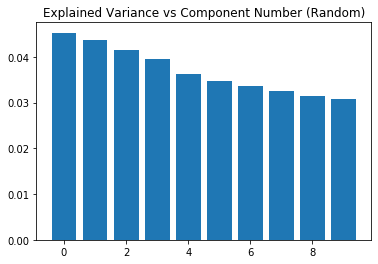

In [165]:
pca_r = PCA(n_components = 10)
pca_r.fit(np.random.rand(70,100))
plt.bar(range(10), pca_r.explained_variance_ratio_)
plt.title("Explained Variance vs Component Number (Random)")

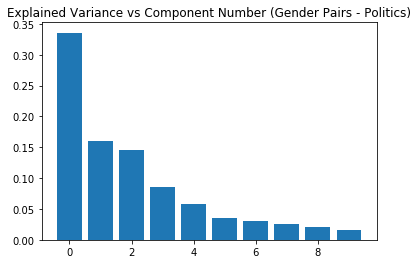

In [140]:
gpol = getg(mpol, "Gender Pairs - Politics", True)

## Regression for bias testing

In [189]:
def regress(g1, m1, g2, m2, wordlist):
    x = np.array([gproj(g1, m1, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    y = np.array([gproj(g2, m2, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope, p_value

In [190]:
regress(gpol, mpol, getg(mpol_s), mpol_s, proflist)

0.31522945


(0.7564479357792341, 1.1464826034410933e-07)